# Code example FedAVG and FedProx

## 問題定義

- 實現聯邦學習算法，分別練習客戶端數據集為獨立同分布 (i.i.d.) 或非獨立同分布 (non-iid) 的情況。

- 使用卷積神經網絡和 cifar10 數據集進行實驗。

- 首先以資料完全集中方式訓練網絡，並實現 FedAvg 算法處理 i.i.d. 的客戶端數據集。

- 接著丟棄 i.i.d. 假設，改為以非 i.i.d. 方式切割數據集，並實現 FedProx 算法處理非 i.i.d. 的客戶端數據集。

- 將 FedProx 結果與 FedAvg 結果進行比較，並與所有資料集中訓練的結果進行對比。

# Packege & Env.

In [1]:
# Importing required libraries
import numpy as np
import matplotlib.pyplot as plt
import math
import os, sys
import random
import copy
import string

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision
import torchvision.transforms as transforms
from typing import Callable, List, Optional, Tuple
from torch.utils.data import random_split
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import MultiStepLR, StepLR
import torch.optim as optim

from tqdm.notebook import tqdm


# Setting.

In [2]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

In [3]:
device

device(type='cpu')

# DL Class. CNN. 簡單的 CNN 網路結構

In [4]:
# CNN
class Deep_CNN(nn.Module):
    """
    Implement the network architecture which was used in "Personalized Federated Learning: A Meta-Learning Approach" Paper.
    """
    def __init__(self, num_classes):
        super(Deep_CNN, self).__init__()

        # First layer
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Second layer
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)

        # First Hidden layer
        self.fc1 = nn.Linear(16 * 5 *5, 120)

        # Second Hidden layer
        self.fc2 = nn.Linear(120, 84)

        # Classifier
        self.fc3 = nn.Linear(84,num_classes)

        # Activation Function
        self.relu = nn.ReLU()

        # Dropout
        self.dropout = nn.Dropout( p= 0.2)


    def forward(self,x):
        # First Layer
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)

        # Second Layer
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)

        x = torch.flatten(x, start_dim = 1)

        # First Hidden layer
        x = self.fc1(x)
        x = self.relu(x)

        # Second Hidden layer
        x = self.fc2(x)
        x = self.relu(x)

        # Classifier
        x = self.fc3(x)

        return x

# Local, Centralization Case. 集中式訓練方法

## 預處理

In [5]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

torch.manual_seed(2045)
max_epochs = 1000
batch_size = 100

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:10<00:00, 15608997.49it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


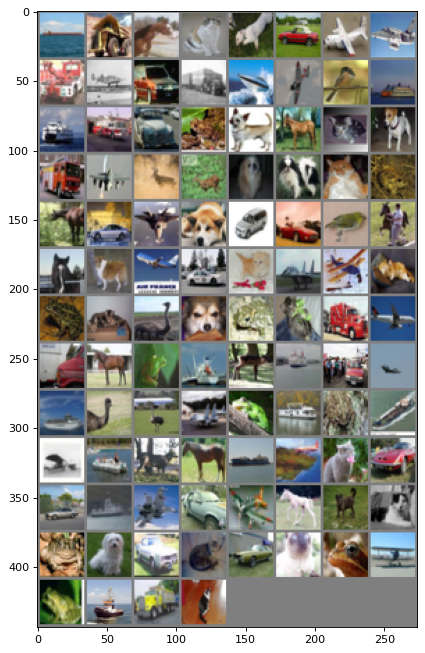

 ship truck horse   cat   dog   car plane plane truck plane   car truck  ship plane  bird  ship  ship truck   car  frog   dog horse   cat   dog truck plane  deer  deer   dog   dog   cat  frog horse   car plane   dog   car   car  bird horse horse   dog plane   car   cat plane plane   cat  frog   cat  bird   dog  frog   cat truck plane truck horse  frog  ship  deer  ship   car plane  ship  bird  bird plane  frog  ship  frog  ship plane  ship  deer horse  ship plane   cat   car   car  ship plane   car plane horse   dog   cat  frog   dog   car   cat   car   cat  frog plane  frog  ship truck   cat


In [6]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(8, 10), dpi=80)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

# 合理檢驗

## 確保模型可以在少量資料上實現 overfitting，如果損失值無法降為 0，則模型複雜度不夠。

In [7]:
# Model
Net = Deep_CNN(10)
Net.to(device)

# Define Loss function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Net.parameters(), lr = 0.01, momentum = 0.9)
# scheduler = StepLR(optimizer, step_size=1, gamma=0.99)

train_losses = []
train_accs = []

validation_losses = []
val_accs = []

dataiter = iter(trainloader)
train_data, train_labels = next(dataiter)

val_dataiter = iter(testloader)
val_data, val_labels = next(val_dataiter)

max_epochs = 1000

# Loop over epochs
for epoch in tqdm(range(max_epochs)):

    running_trainloss, running_valloss, running_loss, train_acc = 0.0, 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0

    # Training
    # Transfer to GPU
    train_data, train_labels = train_data.to(device), train_labels.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # Model computations
    # forward + backward + optimize
    batch_train_outputs = Net(train_data)

    loss = criterion(batch_train_outputs, train_labels.long())
    loss.backward()
    optimizer.step()
    # scheduler.step()
    # print statistics
    running_trainloss += loss.item()
    running_loss += loss.item()

    train_acc += torch.sum(torch.argmax(batch_train_outputs, dim =1) ==  train_labels.long()) / torch.numel(train_labels)

    if train_cnt % 100 == 99:    # print every 10 mini-batches
        print("Cost of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_loss / 10))
        running_loss = 0.0

    train_cnt += 1

    # Validation
    running_loss, val_acc = 0.0, 0.0

    with torch.set_grad_enabled(False):
        #for val_data, val_labels in tqdm(validation_generator):
        # Transfer to GPU
        val_data, val_labels = val_data.to(device), val_labels.to(device)

        # Model computations
        # forward + backward + optimize
        batch_outputs = Net(val_data)

        val_loss = criterion(batch_outputs, val_labels.long())

        running_valloss += val_loss.item()
        running_loss += val_loss.item()

        val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  val_labels.long()) / torch.numel(val_labels)

        if val_cnt % 10 == 9:    # print every 10 mini-batches
            print("Cost of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_loss / 10))
            running_loss = 0.0

        val_cnt += 1

    train_acc = train_acc.cpu()
    val_acc = val_acc.cpu()
    train_losses.append(running_trainloss / train_cnt)
    train_accs.append(train_acc / train_cnt * 100)
    validation_losses.append(running_valloss / val_cnt)
    val_accs.append(val_acc / val_cnt * 100)

  0%|          | 0/1000 [00:00<?, ?it/s]

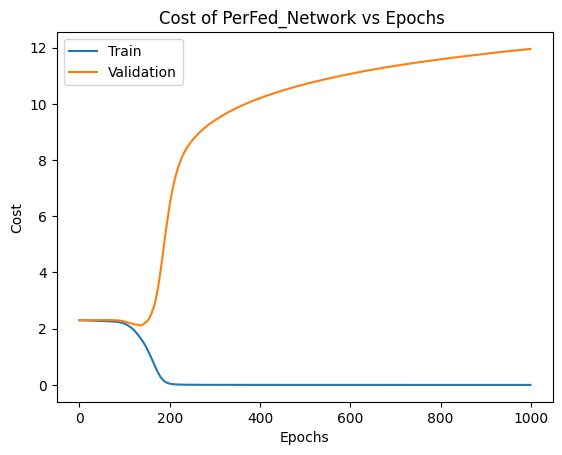

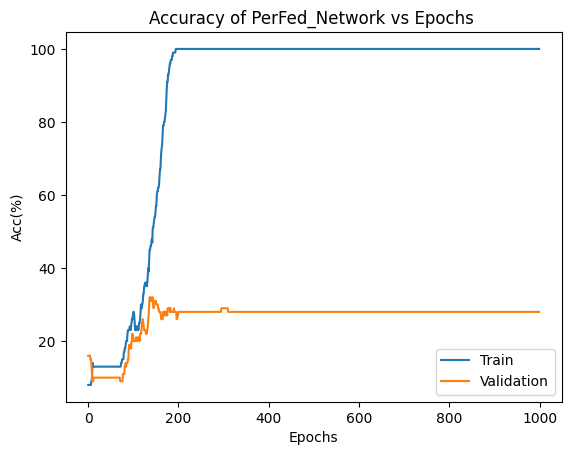

In [8]:
plot_cost, plot_acc = 1, 1
# plot the cost
if plot_cost:
    plt.plot(train_losses)
    plt.plot(validation_losses)
    plt.title("Cost of PerFed_Network vs Epochs ")
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

if plot_acc:
    plt.plot(train_accs)
    plt.plot(val_accs)
    plt.title("Accuracy of PerFed_Network vs Epochs ")
    plt.ylabel('Acc(%)')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

## 集中式訓練

In [9]:
# Model
Net = Deep_CNN(10)
Net.to(device)

# Define Loss function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Net.parameters(), lr = 0.05, momentum = 0.9)
# scheduler = StepLR(optimizer, step_size=1, gamma=0.99)

train_losses = []
validation_losses = []

train_accs = []
val_accs = []

max_epochs = 10

# Loop over epochs
for epoch in tqdm(range(max_epochs)):

    running_trainloss, running_valloss, running_loss, train_acc = 0.0, 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0

    # Training
    for train_data, train_labels in tqdm(trainloader):
        # Transfer to GPU
        train_data, train_labels = train_data.to(device), train_labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # Model computations
        # forward + backward + optimize
        batch_train_outputs = Net(train_data)
        # print(batch_train_outputs.shape, train_labels.shape)
        # break
        loss = criterion(batch_train_outputs, train_labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_trainloss += loss.item()
        running_loss += loss.item()

        train_acc += torch.sum(torch.argmax(batch_train_outputs, dim =1) ==  train_labels.long()) / torch.numel(train_labels)

        if train_cnt % 100 == 99:    # print every 10 mini-batches
            print("Cost of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_loss / 100))
            running_loss = 0.0

        train_cnt += 1

    # Validation
    running_loss, val_acc = 0.0, 0.0

    with torch.set_grad_enabled(False):
        for val_data, val_labels in tqdm(testloader):
            # Transfer to GPU
            val_data, val_labels = val_data.to(device), val_labels.to(device)

            # Model computations
            # forward + backward + optimize
            batch_outputs = Net(val_data)

            val_loss = criterion(batch_outputs, val_labels.long())

            running_valloss += val_loss.item()
            running_loss += val_loss.item()

            val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  val_labels.long()) / torch.numel(val_labels)

            if val_cnt % 100 == 99:    # print every 10 mini-batches
                print("Cost of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_loss / 100))
                running_loss = 0.0

            val_cnt += 1


    train_acc = train_acc.cpu()
    val_acc = val_acc.cpu()
    # scheduler.step()
    train_losses.append(running_trainloss / train_cnt)
    train_accs.append(train_acc / train_cnt * 100)
    validation_losses.append(running_valloss / val_cnt)
    val_accs.append(val_acc / val_cnt * 100)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 1 : 2.167954
Cost of Train data after 200 iterations in epoch 1 : 1.815094
Cost of Train data after 300 iterations in epoch 1 : 1.627919
Cost of Train data after 400 iterations in epoch 1 : 1.600654
Cost of Train data after 500 iterations in epoch 1 : 1.487547


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 1 : 1.434320


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 2 : 1.452377
Cost of Train data after 200 iterations in epoch 2 : 1.422922
Cost of Train data after 300 iterations in epoch 2 : 1.401734
Cost of Train data after 400 iterations in epoch 2 : 1.381751
Cost of Train data after 500 iterations in epoch 2 : 1.354068


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 2 : 1.324516


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 3 : 1.272320
Cost of Train data after 200 iterations in epoch 3 : 1.289023
Cost of Train data after 300 iterations in epoch 3 : 1.288622
Cost of Train data after 400 iterations in epoch 3 : 1.285536
Cost of Train data after 500 iterations in epoch 3 : 1.250402


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 3 : 1.321650


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 4 : 1.183725
Cost of Train data after 200 iterations in epoch 4 : 1.186888
Cost of Train data after 300 iterations in epoch 4 : 1.174065
Cost of Train data after 400 iterations in epoch 4 : 1.244843
Cost of Train data after 500 iterations in epoch 4 : 1.207664


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 4 : 1.261420


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 5 : 1.133710
Cost of Train data after 200 iterations in epoch 5 : 1.164015
Cost of Train data after 300 iterations in epoch 5 : 1.152466
Cost of Train data after 400 iterations in epoch 5 : 1.159312
Cost of Train data after 500 iterations in epoch 5 : 1.161412


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 5 : 1.249539


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 6 : 1.078746
Cost of Train data after 200 iterations in epoch 6 : 1.107333
Cost of Train data after 300 iterations in epoch 6 : 1.110945
Cost of Train data after 400 iterations in epoch 6 : 1.127064
Cost of Train data after 500 iterations in epoch 6 : 1.097022


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 6 : 1.231483


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 7 : 1.054461
Cost of Train data after 200 iterations in epoch 7 : 1.047260
Cost of Train data after 300 iterations in epoch 7 : 1.058134
Cost of Train data after 400 iterations in epoch 7 : 1.086279
Cost of Train data after 500 iterations in epoch 7 : 1.095990


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 7 : 1.278613


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 8 : 1.011061
Cost of Train data after 200 iterations in epoch 8 : 1.032235
Cost of Train data after 300 iterations in epoch 8 : 1.076416
Cost of Train data after 400 iterations in epoch 8 : 1.067840
Cost of Train data after 500 iterations in epoch 8 : 1.088029


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 8 : 1.300288


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 9 : 1.001900
Cost of Train data after 200 iterations in epoch 9 : 1.028768
Cost of Train data after 300 iterations in epoch 9 : 1.036747
Cost of Train data after 400 iterations in epoch 9 : 1.049148
Cost of Train data after 500 iterations in epoch 9 : 1.079364


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 9 : 1.262674


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 10 : 0.957250
Cost of Train data after 200 iterations in epoch 10 : 0.983320
Cost of Train data after 300 iterations in epoch 10 : 1.032592
Cost of Train data after 400 iterations in epoch 10 : 1.060952
Cost of Train data after 500 iterations in epoch 10 : 1.091507


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 10 : 1.308777


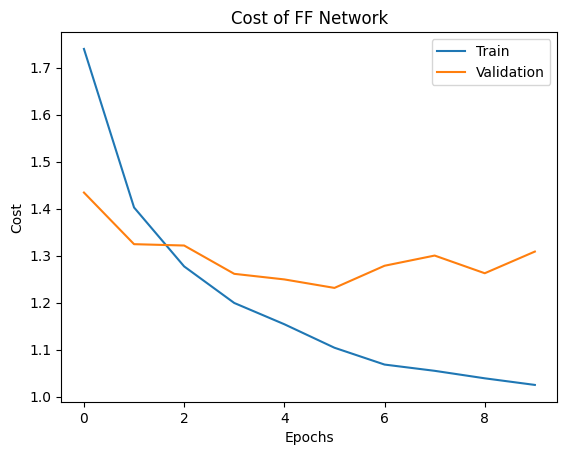

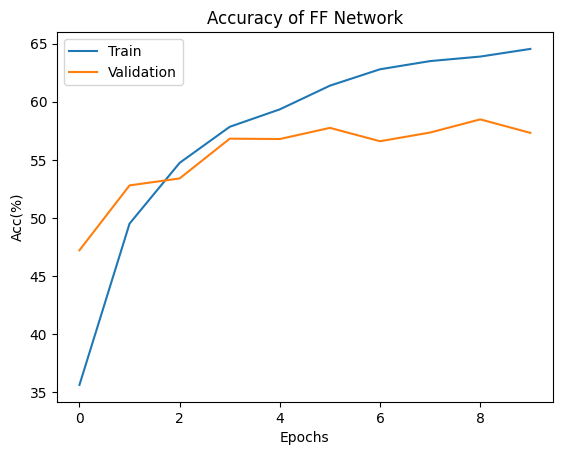

In [10]:
plot_cost, plot_acc = 1, 1
# plot the cost
if plot_cost:
    plt.plot(train_losses)
    plt.plot(validation_losses)
    plt.title("Cost of FF Network")
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

if plot_acc:
    plt.plot(train_accs)
    plt.plot(val_accs)
    plt.title("Accuracy of FF Network")
    plt.ylabel('Acc(%)')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

In [11]:
# Model
Net2 = Deep_CNN(10)
Net2.to(device)

# Define Loss function and Optimizer
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.SGD(Net2.parameters(), lr = 0.01, momentum = 0.9)
# scheduler = StepLR(optimizer, step_size=1, gamma=0.99)

train_losses2 = []
validation_losses2 = []

train_accs2 = []
val_accs2 = []

max_epochs = 10

# Loop over epochs
for epoch in tqdm(range(max_epochs)):

    running_trainloss, running_valloss, running_loss, train_acc = 0.0, 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0

    # Training
    for train_data, train_labels in tqdm(trainloader):
        # Transfer to GPU
        train_data, train_labels = train_data.to(device), train_labels.to(device)

        # zero the parameter gradients
        optimizer2.zero_grad()

        # Model computations
        # forward + backward + optimize
        batch_train_outputs = Net2(train_data)

        loss = criterion2(batch_train_outputs, train_labels)
        loss.backward()
        optimizer2.step()

        # print statistics
        running_trainloss += loss.item()
        running_loss += loss.item()

        train_acc += torch.sum(torch.argmax(batch_train_outputs, dim =1) ==  train_labels.long()) / torch.numel(train_labels)

        if train_cnt % 100 == 99:    # print every 10 mini-batches
            print("Cost of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_loss / 100))
            running_loss = 0.0

        train_cnt += 1

    # Validation
    running_loss, val_acc = 0.0, 0.0

    with torch.set_grad_enabled(False):
        for val_data, val_labels in tqdm(testloader):
            # Transfer to GPU
            val_data, val_labels = val_data.to(device), val_labels.to(device)

            # Model computations
            # forward + backward + optimize
            batch_outputs = Net2(val_data)

            val_loss = criterion2(batch_outputs, val_labels.long())

            running_valloss += val_loss.item()
            running_loss += val_loss.item()

            val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  val_labels.long()) / torch.numel(val_labels)

            if val_cnt % 100 == 99:    # print every 10 mini-batches
                print("Cost of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_loss / 100))
                running_loss = 0.0

            val_cnt += 1

    train_acc = train_acc.cpu()
    val_acc = val_acc.cpu()

    # scheduler.step()
    train_losses2.append(running_trainloss / train_cnt)
    train_accs2.append(train_acc / train_cnt * 100)
    validation_losses2.append(running_valloss / val_cnt)
    val_accs2.append(val_acc / val_cnt * 100)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 1 : 2.288449
Cost of Train data after 200 iterations in epoch 1 : 2.115655
Cost of Train data after 300 iterations in epoch 1 : 1.883157
Cost of Train data after 400 iterations in epoch 1 : 1.741329
Cost of Train data after 500 iterations in epoch 1 : 1.612105


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 1 : 1.595329


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 2 : 1.528734
Cost of Train data after 200 iterations in epoch 2 : 1.492122
Cost of Train data after 300 iterations in epoch 2 : 1.443529
Cost of Train data after 400 iterations in epoch 2 : 1.423413
Cost of Train data after 500 iterations in epoch 2 : 1.369744


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 2 : 1.326380


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 3 : 1.341771
Cost of Train data after 200 iterations in epoch 3 : 1.310596
Cost of Train data after 300 iterations in epoch 3 : 1.311020
Cost of Train data after 400 iterations in epoch 3 : 1.269291
Cost of Train data after 500 iterations in epoch 3 : 1.285107


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 3 : 1.242963


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 4 : 1.218971
Cost of Train data after 200 iterations in epoch 4 : 1.182877
Cost of Train data after 300 iterations in epoch 4 : 1.194097
Cost of Train data after 400 iterations in epoch 4 : 1.188068
Cost of Train data after 500 iterations in epoch 4 : 1.181011


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 4 : 1.168670


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 5 : 1.133430
Cost of Train data after 200 iterations in epoch 5 : 1.109875
Cost of Train data after 300 iterations in epoch 5 : 1.117914
Cost of Train data after 400 iterations in epoch 5 : 1.118625
Cost of Train data after 500 iterations in epoch 5 : 1.116679


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 5 : 1.133828


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 6 : 1.061641
Cost of Train data after 200 iterations in epoch 6 : 1.047181
Cost of Train data after 300 iterations in epoch 6 : 1.049307
Cost of Train data after 400 iterations in epoch 6 : 1.043669
Cost of Train data after 500 iterations in epoch 6 : 1.048578


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 6 : 1.098608


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 7 : 1.001064
Cost of Train data after 200 iterations in epoch 7 : 1.003489
Cost of Train data after 300 iterations in epoch 7 : 0.999991
Cost of Train data after 400 iterations in epoch 7 : 1.000603
Cost of Train data after 500 iterations in epoch 7 : 0.989291


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 7 : 1.080418


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 8 : 0.939314
Cost of Train data after 200 iterations in epoch 8 : 0.941923
Cost of Train data after 300 iterations in epoch 8 : 0.960242
Cost of Train data after 400 iterations in epoch 8 : 0.946954
Cost of Train data after 500 iterations in epoch 8 : 0.957620


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 8 : 1.068175


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 9 : 0.883730
Cost of Train data after 200 iterations in epoch 9 : 0.906789
Cost of Train data after 300 iterations in epoch 9 : 0.906932
Cost of Train data after 400 iterations in epoch 9 : 0.931859
Cost of Train data after 500 iterations in epoch 9 : 0.926331


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 9 : 1.076943


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 10 : 0.850834
Cost of Train data after 200 iterations in epoch 10 : 0.855116
Cost of Train data after 300 iterations in epoch 10 : 0.873134
Cost of Train data after 400 iterations in epoch 10 : 0.898907
Cost of Train data after 500 iterations in epoch 10 : 0.866046


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 10 : 1.050461


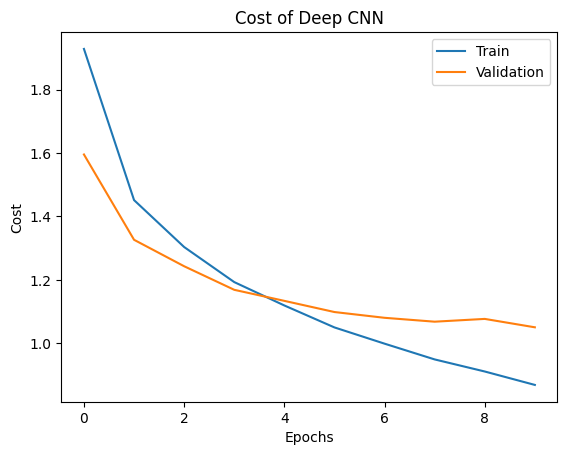

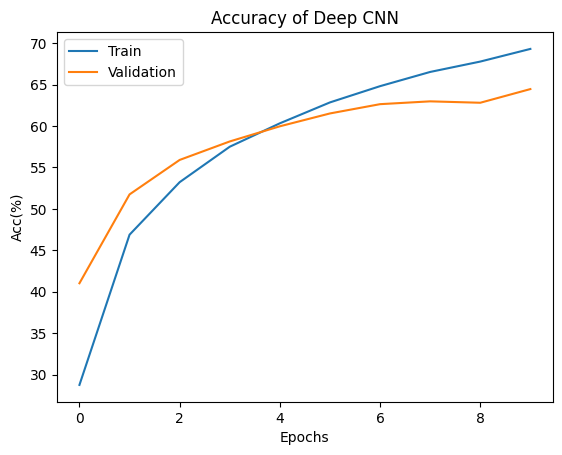

In [12]:
plot_cost, plot_acc = 1, 1
# plot the cost
if plot_cost:
    plt.plot(train_losses2)
    plt.plot(validation_losses2)
    plt.title("Cost of Deep CNN")
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

if plot_acc:
    plt.plot(train_accs2)
    plt.plot(val_accs2)
    plt.title("Accuracy of Deep CNN")
    plt.ylabel('Acc(%)')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

Let’s quickly save our trained model:

In [13]:
PATH = 'PerFed_Net.pth'
torch.save(Net.state_dict(), PATH)

# IID Case. Federated Learning (IID)

在獨立同分布下進行聯邦學習

## 均勻的切分資料分給不同客戶端

In [14]:
# IID case: all the clients have images of all the classes
transform2 = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

torch.manual_seed(2045)

batch_size2 = 50

trainset2 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform2)

testset2 = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform2)

testloader2 = torch.utils.data.DataLoader(testset2, batch_size=batch_size2, shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

n = 100
N = len(trainset2.__dict__['targets'])
N_prime = len(testset2.__dict__['targets'])
n_i = N // n
n_i_prime = N_prime // n

train_sets2 = []
test_sets2 = []
for i in range(n):
    subset1, trainset2 = random_split(trainset2, (n_i ,N - n_i))
    train_sets2.append(subset1)
    N = N - n_i

    subset2, testset2 = random_split(testset2, (n_i_prime ,N_prime - n_i_prime))
    test_sets2.append(subset2)
    N_prime = N_prime - n_i_prime

train_loaders2 = [torch.utils.data.DataLoader(train_sets2[i], batch_size=batch_size2, shuffle=True, num_workers=2) for i in range(n)]
test_loaders2 = [torch.utils.data.DataLoader(test_sets2[i], batch_size=batch_size2, shuffle=True, num_workers=2) for i in range(n)]

Files already downloaded and verified
Files already downloaded and verified


In [15]:
labels = []
for train_data, train_labels in train_loaders2[9]:
    labels.append(train_labels)

In [16]:
x = 0
for i in labels:
    for j in i:
        if j == 2:
            x += 1

print(x)

43


# FedAVG 演算法

In [17]:
class FedAvg_ClientUpdate(object):

    def __init__(self, train_loader):

        self.train_loader =  train_loader
        # Define Loss function
        self.criterion = nn.CrossEntropyLoss()

    def update(self, net, max_epochs, lr):
        optimizer = optim.SGD(net.parameters(), lr = lr, momentum = 0.9)

        train_losses = []
        validation_losses = []

        train_accs = []
        val_accs = []

        # Loop over epochs
        for epoch in range(max_epochs):

            running_trainloss, train_acc = 0.0, 0.0
            train_cnt = 0

            # Training
            for train_data, train_labels in self.train_loader:
                # Transfer to GPU
                train_data, train_labels = train_data.to(device), train_labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # Model computations
                # forward + backward + optimize
                batch_train_outputs = net(train_data)

                loss = self.criterion(batch_train_outputs, train_labels)
                loss.backward()
                optimizer.step()

                # print statistics
                running_trainloss += loss.item()

                train_acc += torch.sum(torch.argmax(batch_train_outputs, dim =1) ==  train_labels.long()) / torch.numel(train_labels)

                train_cnt += 1

            train_losses.append(running_trainloss / train_cnt)
            train_accs.append(train_acc / train_cnt )

        return net.state_dict(), sum(train_losses) / len(train_losses), sum(train_accs) / len(train_accs)

    def FedAvg(self, w_dict, w_prime_dict, coeff):
        for k in w_dict.keys():
            w_dict[k] = w_dict[k] + coeff * w_prime_dict[k]
        return w_dict

# FedAvg 訓練

In [18]:
# Model
Net3 = Deep_CNN(10)
Net3.to(device)

# # Define Loss function and Optimizer
criterion3 = nn.CrossEntropyLoss()

train_losses3 = []
validation_losses3 = []

train_accs3 = []
val_accs3 = []

max_rounds = 100
C = 0.1
E = 5
learning_rate = 0.01
w_dict = copy.deepcopy(Net3.state_dict())

# Loop over epochs
for round in tqdm(range(max_rounds)):
    running_trainloss, running_valloss, train_acc = 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0
    clients = random.sample(list(np.arange(n)), k = int(C * n))
    coeffs = [ 1 / len(clients) for i in range(n)]

    for k in w_dict.keys():
        w_dict[k] = torch.zeros_like(w_dict[k])

    # Training
    for i in clients:
        cl_upd = FedAvg_ClientUpdate(train_loaders2[i])
        w_prime_dict, train_loss, acc = cl_upd.update(copy.deepcopy(Net3).to(device), E, learning_rate)
        w_dict = cl_upd.FedAvg(w_dict, w_prime_dict, coeffs[i])
        print("Cost of Train data for client %i in round %i for %i epochs: %f" %(i+1, round + 1, E, train_loss))
        running_trainloss += train_loss
        train_acc += acc
        train_cnt += 1

    Net3.load_state_dict(w_dict)
    # print("******", Net3.state_dict()['fc1.bias'])

    val_acc = 0
    with torch.set_grad_enabled(False):
        for val_data, val_labels in testloader2:
            # Transfer to GPU
            val_data, val_labels = val_data.to(device), val_labels.to(device)

            # Model computations
            # forward + backward + optimize
            batch_outputs = Net3(val_data)

            val_loss = criterion3(batch_outputs, val_labels.long())

            running_valloss += val_loss.item()

            val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  val_labels.long()) / torch.numel(val_labels)

            val_cnt += 1

    # learning_rate = learning_rate * 0.99
    print("-"*10)
    print("Cost of Train data for in round %i: %f" %(round + 1, running_trainloss / train_cnt))
    print("Cost of Validation data for in round %i: %f" %(round + 1, running_valloss / val_cnt))
    print("Acc of Train data for in round %i: %f" %(round + 1, train_acc / train_cnt * 100))
    print("Acc of Validation data for in round %i: %f" %(round + 1, val_acc / val_cnt * 100))
    print("-"*10)

    train_acc = train_acc.cpu()
    val_acc = val_acc.cpu()
    train_losses3.append(running_trainloss / train_cnt)
    train_accs3.append(train_acc / train_cnt * 100)
    validation_losses3.append(running_valloss / val_cnt)
    val_accs3.append(val_acc / val_cnt * 100)

  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Train data for client 27 in round 1 for 5 epochs: 2.299919
Cost of Train data for client 18 in round 1 for 5 epochs: 2.299708
Cost of Train data for client 31 in round 1 for 5 epochs: 2.294720
Cost of Train data for client 86 in round 1 for 5 epochs: 2.300695
Cost of Train data for client 56 in round 1 for 5 epochs: 2.300166
Cost of Train data for client 79 in round 1 for 5 epochs: 2.297811
Cost of Train data for client 5 in round 1 for 5 epochs: 2.296465
Cost of Train data for client 42 in round 1 for 5 epochs: 2.297802
Cost of Train data for client 6 in round 1 for 5 epochs: 2.296812
Cost of Train data for client 77 in round 1 for 5 epochs: 2.298937
----------
Cost of Train data for in round 1: 2.298304
Cost of Validation data for in round 1: 2.298423
Acc of Train data for in round 1: 12.124000
Acc of Validation data for in round 1: 10.800006
----------
Cost of Train data for client 20 in round 2 for 5 epochs: 2.292247
Cost of Train data for client 29 in round 2 for 5 epochs:

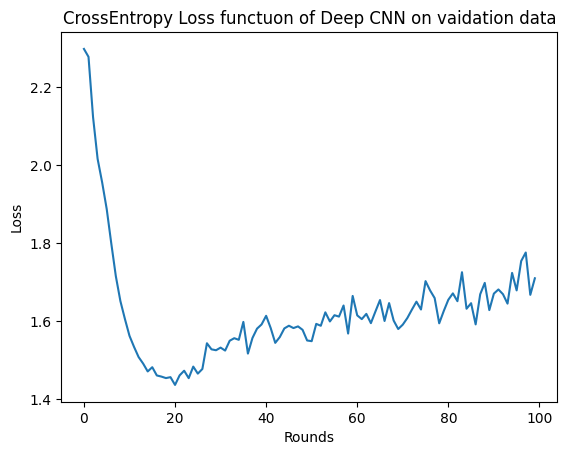

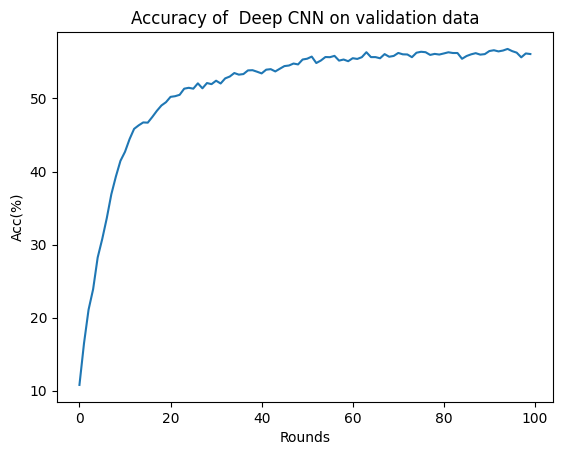

In [19]:
plot_cost, plot_acc = 1, 1
# plot the cost
if plot_cost:
    # plt.plot(train_losses3)
    plt.plot(validation_losses3)
    plt.title("CrossEntropy Loss functuon of Deep CNN on vaidation data")
    plt.ylabel('Loss')
    plt.xlabel('Rounds')
    # plt.legend(labels = ["Train","Validation"])
    plt.show()

if plot_acc:
    # plt.plot(train_accs3)
    plt.plot(val_accs3)
    plt.title("Accuracy of  Deep CNN on validation data")
    plt.ylabel('Acc(%)')
    plt.xlabel('Rounds')
    # plt.legend(labels = ["Train","Validation"])
    plt.show()

In [20]:
PATH = 'Fed_Primal_1.pth'
torch.save(Net3.state_dict(), PATH)

In [21]:
# Model
Net4 = Deep_CNN(10)
Net4.to(device)

# # Define Loss function and Optimizer
criterion4 = nn.CrossEntropyLoss()

train_losses4 = []
validation_losses4 = []

train_accs4 = []
val_accs4 = []

max_rounds = 100
C = 0.1
E = 5
learning_rate = 0.02
w_dict = copy.deepcopy(Net4.state_dict())

# Loop over epochs
for round in tqdm(range(max_rounds)):
    running_trainloss, running_valloss, train_acc = 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0
    clients = random.sample(list(np.arange(n)), k = int(C * n))
    coeffs = [ 1 / len(clients) for i in range(n)]

    for k in w_dict.keys():
        w_dict[k] = torch.zeros_like(w_dict[k])

    # Training
    for i in clients:
        cl_upd = FedAvg_ClientUpdate(train_loaders2[i])
        w_prime_dict, train_loss, acc = cl_upd.update(copy.deepcopy(Net4).to(device), E, learning_rate)
        w_dict = cl_upd.FedAvg(w_dict, w_prime_dict, coeffs[i])
        print("Cost of Train data for client %i in round %i for %i epochs: %f" %(i+1, round + 1, E, train_loss))
        running_trainloss += train_loss
        train_acc += acc
        train_cnt += 1

    Net4.load_state_dict(w_dict)
    # print("******", Net3.state_dict()['fc1.bias'])

    val_acc = 0
    with torch.set_grad_enabled(False):
        for val_data, val_labels in testloader2:
            # Transfer to GPU
            val_data, val_labels = val_data.to(device), val_labels.to(device)

            # Model computations
            # forward + backward + optimize
            batch_outputs = Net4(val_data)

            val_loss = criterion4(batch_outputs, val_labels.long())

            running_valloss += val_loss.item()

            val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  val_labels.long()) / torch.numel(val_labels)

            val_cnt += 1

    # learning_rate = learning_rate * 0.99
    print("-"*10)
    print("Cost of Train data for in round %i: %f" %(round + 1, running_trainloss / train_cnt))
    print("Cost of Validation data for in round %i: %f" %(round + 1, running_valloss / val_cnt))
    print("Acc of Train data for in round %i: %f" %(round + 1, train_acc / train_cnt * 100))
    print("Acc of Validation data for in round %i: %f" %(round + 1, val_acc / val_cnt * 100))
    print("-"*10)

    train_acc = train_acc.cpu()
    val_acc = val_acc.cpu()

    train_losses4.append(running_trainloss / train_cnt)
    train_accs4.append(train_acc / train_cnt * 100)
    validation_losses4.append(running_valloss / val_cnt)
    val_accs4.append(val_acc / val_cnt * 100)

  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Train data for client 86 in round 1 for 5 epochs: 2.299216
Cost of Train data for client 84 in round 1 for 5 epochs: 2.300114
Cost of Train data for client 91 in round 1 for 5 epochs: 2.292166
Cost of Train data for client 35 in round 1 for 5 epochs: 2.291675
Cost of Train data for client 13 in round 1 for 5 epochs: 2.292414
Cost of Train data for client 76 in round 1 for 5 epochs: 2.296947
Cost of Train data for client 73 in round 1 for 5 epochs: 2.299596
Cost of Train data for client 33 in round 1 for 5 epochs: 2.297955
Cost of Train data for client 63 in round 1 for 5 epochs: 2.299765
Cost of Train data for client 8 in round 1 for 5 epochs: 2.287239
----------
Cost of Train data for in round 1: 2.295709
Cost of Validation data for in round 1: 2.296849
Acc of Train data for in round 1: 11.736000
Acc of Validation data for in round 1: 9.950006
----------
Cost of Train data for client 45 in round 2 for 5 epochs: 2.265167
Cost of Train data for client 18 in round 2 for 5 epochs:

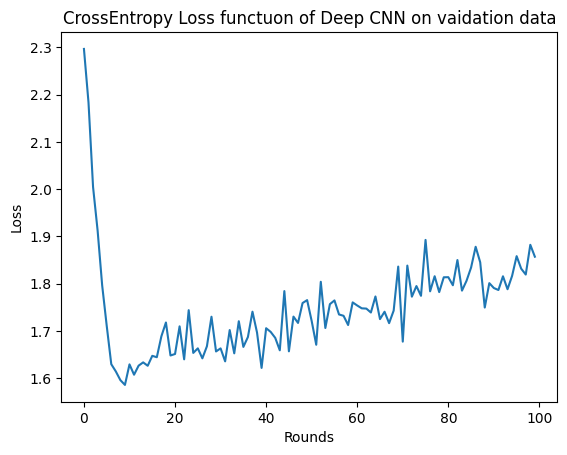

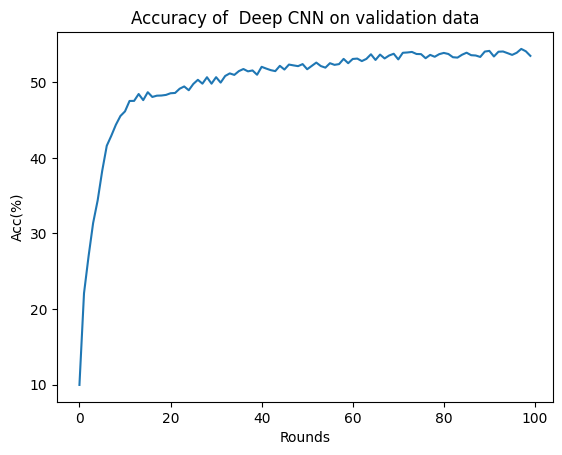

In [22]:
plot_cost, plot_acc = 1, 1
# plot the cost
if plot_cost:
    # plt.plot(train_losses3)
    plt.plot(validation_losses4)
    plt.title("CrossEntropy Loss functuon of Deep CNN on vaidation data")
    plt.ylabel('Loss')
    plt.xlabel('Rounds')
    # plt.legend(labels = ["Train","Validation"])
    plt.show()

if plot_acc:
    # plt.plot(train_accs3)
    plt.plot(val_accs4)
    plt.title("Accuracy of  Deep CNN on validation data")
    plt.ylabel('Acc(%)')
    plt.xlabel('Rounds')
    # plt.legend(labels = ["Train","Validation"])
    plt.show()

In [23]:
PATH = 'Fed_Primal_2.pth'
torch.save(Net4.state_dict(), PATH)

# NON-IID Case. Federated Learning (Non-IID Dataset)

在非獨立同分布下進行聯邦學習

## 均勻的切分資料分給不同客戶端

In [24]:
# NON-IID case: every client has images of two categories chosen from [0, 1], [2, 3], [4, 5], [6, 7], or [8, 9].
class Cifar10(torch.utils.data.Dataset):

    def __init__(self, train_set, list_IDs):
        self.train_set = train_set
        self.list_IDs = list_IDs

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    def __getitem__(self,index):
        ind = self.list_IDs[index]
        return self.train_set[ind]

In [25]:
def cifar_noniid(dataset, num_users,  batch_size):
    """
    Sample non-I.I.D client data from CIFAR10 dataset
    :param dataset:
    :param num_users:
    :return:
    """
    n = num_users
    n_i = len(dataset) // n // 2 # each class items per client
    cifar_labels = { i: [] for i in range(10) }

    for i in range(len(dataset)):
        cifar_labels[dataset[i][1]].append(i)

    for i in range(10):
        cifar_labels[i] = [cifar_labels[i][x:x+n_i] for x in range(0, len(cifar_labels[i]), n_i)]

    users_dict = dict()
    i = 0
    for user in range(n):
        if len(cifar_labels[i]) > 0:
            users_dict[user] = cifar_labels[i][0] + cifar_labels[i+1][0]
            del cifar_labels[i][0]
            del cifar_labels[i+1][0]

        else :
            i = i + 2
            users_dict[user] = cifar_labels[i][0] + cifar_labels[i+1][0]
            del cifar_labels[i][0]
            del cifar_labels[i+1][0]

    train_loaders = [torch.utils.data.DataLoader(Cifar10(dataset,users_dict[i]), batch_size=batch_size,shuffle=True, num_workers = 2) for i in range(n)]

    return train_loaders

In [26]:
transform3 = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

torch.manual_seed(2045)
n = 100
batch_size3 = 50

trainset3 = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform3)

trainloader3 = torch.utils.data.DataLoader(trainset3, batch_size=batch_size3,
                                          shuffle= True, num_workers=2)

testset3 = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform3)

testloader3 = torch.utils.data.DataLoader(testset3, batch_size=batch_size3,
                                         shuffle=False, num_workers=2)

train_loaders3 = cifar_noniid(trainset3, n, batch_size3)

Files already downloaded and verified
Files already downloaded and verified


In [27]:
labels = []

for train_data, train_labels in train_loaders3[20]:
    labels.append(train_labels)

In [28]:
x = 0
for i in labels:
    for j in i:
        if j == 3:
            x += 1

print(x)

250


# FedProx 演算法

In [29]:
class FedAvg_ClientUpdate(object):

    def __init__(self, train_loader):

        self.train_loader =  train_loader
        # Define Loss function
        self.criterion = nn.CrossEntropyLoss()

    def update(self, net, max_epochs, lr):
        optimizer = optim.SGD(net.parameters(), lr = lr, momentum = 0.9)

        train_losses = []
        validation_losses = []

        train_accs = []
        val_accs = []

        # Loop over epochs
        for epoch in range(max_epochs):

            running_trainloss, train_acc = 0.0, 0.0
            train_cnt = 0

            # Training
            for train_data, train_labels in self.train_loader:
                # Transfer to GPU
                train_data, train_labels = train_data.to(device), train_labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # Model computations
                # forward + backward + optimize
                batch_train_outputs = net(train_data)

                loss = self.criterion(batch_train_outputs, train_labels)
                loss.backward()
                optimizer.step()

                # print statistics
                running_trainloss += loss.item()

                train_acc += torch.sum(torch.argmax(batch_train_outputs, dim =1) ==  train_labels.long()) / torch.numel(train_labels)

                train_cnt += 1

            train_losses.append(running_trainloss / train_cnt)
            train_accs.append(train_acc / train_cnt )

        return net.state_dict(), sum(train_losses) / len(train_losses), sum(train_accs) / len(train_accs)

    def FedAvg(self, w_dict, w_prime_dict, coeff):
        for k in w_dict.keys():
            w_dict[k] = w_dict[k] + coeff * w_prime_dict[k]
        return w_dict


class FedProx_ClientUpdate(object):

    def __init__(self, train_loader):

        self.train_loader =  train_loader

        # Define Loss function
        self.criterion = nn.CrossEntropyLoss()

    def loss_function(self, net, w_t,batch_train_outputs, train_labels, mu):
        w_dict = net.state_dict()
        loss1 = self.criterion(batch_train_outputs, train_labels)

        loss2 = 0
        for l in w_dict.keys():
            loss2 += torch.norm(w_dict[l].float() - w_t[l].float(), p = 2)

        return loss1 + (mu /2) * loss2

    def update(self, net, max_epochs, lr, mu):
        optimizer = optim.SGD(net.parameters(), lr = lr, momentum = 0.9)
        w_t = copy.deepcopy(net.state_dict())

        train_losses = []
        validation_losses = []

        train_accs = []
        val_accs = []

        # Loop over epochs
        for epoch in range(max_epochs):

            running_trainloss,  train_acc = 0.0, 0.0
            train_cnt = 0

            # Training
            for train_data, train_labels in self.train_loader:
                # Transfer to GPU
                train_data, train_labels = train_data.to(device), train_labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # Model computations
                # forward + backward + optimize
                batch_train_outputs = net(train_data)

                loss = self.loss_function(net, w_t, batch_train_outputs, train_labels, mu)
                loss.backward()
                optimizer.step()

                # print statistics
                running_trainloss += loss.item()

                train_acc += torch.sum(torch.argmax(batch_train_outputs, dim =1) ==  train_labels.long()) / torch.numel(train_labels)

                train_cnt += 1

            train_losses.append(running_trainloss / train_cnt)
            train_accs.append(train_acc / train_cnt )

        return net.state_dict(), sum(train_losses) / len(train_losses), sum(train_accs)/len(train_accs)

    def FedAvg(self, w_dict, w_prime_dict, coeff):
        for k in w_dict.keys():
            w_dict[k] = w_dict[k] + coeff * w_prime_dict[k]
        return w_dict

# Non-IID Training

非獨立同分布的情境

## FedAvg 訓練

In [30]:
# Model
Net6 =  Deep_CNN(10)
Net6.to(device)

# Define Loss function and Optimizer
criterion6 = nn.CrossEntropyLoss()

train_losses6 = []
validation_losses6 = []

train_accs6 = []
val_accs6 = []

max_rounds = 100
C = 0.1
E = 5
learning_rate = 0.01
w_dict = copy.deepcopy(Net6.state_dict())

# Loop over epochs
for round in tqdm(range(max_rounds)):
    running_trainloss, running_valloss, train_acc = 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0
    clients = random.sample(list(np.arange(n)), k = int(C * n))
    coeffs = [ 1 / len(clients) for i in range(n)]

    for k in w_dict.keys():
        w_dict[k] = torch.zeros_like(w_dict[k])

    # Training
    for i in clients:
        cl_upd = FedAvg_ClientUpdate(train_loaders3[i])
        w_prime_dict, train_loss, acc = cl_upd.update(copy.deepcopy(Net6).to(device), E, learning_rate)
        w_dict = cl_upd.FedAvg(w_dict, w_prime_dict, coeffs[i])
        print("Cost of Train data for client %i in round %i for %i epochs: %f" %(i+1, round + 1, E, train_loss))
        running_trainloss += train_loss
        train_acc += acc
        train_cnt += 1

    Net6.load_state_dict(w_dict)

    val_acc = 0
    with torch.set_grad_enabled(False):
        for val_data, val_labels in testloader3:
            # Transfer to GPU
            val_data, val_labels = val_data.to(device), val_labels.to(device)

            # Model computations
            # forward + backward + optimize
            batch_outputs = Net6(val_data)

            val_loss = criterion6(batch_outputs, val_labels.long())

            running_valloss += val_loss.item()

            val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  val_labels.long()) / torch.numel(val_labels)

            val_cnt += 1

    # learning_rate = learning_rate * 0.99
    print("-"*10)
    print("Cost of Train data for in round %i: %f" %(round + 1, running_trainloss / train_cnt))
    print("Cost of Validation data for in round %i: %f" %(round + 1, running_valloss / val_cnt))
    print("Acc of Train data for in round %i: %f" %(round + 1, train_acc / train_cnt * 100))
    print("Acc of Validation data for in round %i: %f" %(round + 1, val_acc / val_cnt * 100))
    print("-"*10)

    train_acc = train_acc.cpu()
    val_acc = val_acc.cpu()

    train_losses6.append(running_trainloss / train_cnt)
    train_accs6.append(train_acc / train_cnt * 100)
    validation_losses6.append(running_valloss / val_cnt)
    val_accs6.append(val_acc / val_cnt * 100)

  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Train data for client 58 in round 1 for 5 epochs: 1.438100
Cost of Train data for client 43 in round 1 for 5 epochs: 1.387329
Cost of Train data for client 65 in round 1 for 5 epochs: 1.337097
Cost of Train data for client 66 in round 1 for 5 epochs: 1.374676
Cost of Train data for client 98 in round 1 for 5 epochs: 1.313195
Cost of Train data for client 12 in round 1 for 5 epochs: 1.359106
Cost of Train data for client 84 in round 1 for 5 epochs: 1.317343
Cost of Train data for client 14 in round 1 for 5 epochs: 1.303238
Cost of Train data for client 51 in round 1 for 5 epochs: 1.454082
Cost of Train data for client 76 in round 1 for 5 epochs: 1.352513
----------
Cost of Train data for in round 1: 1.363668
Cost of Validation data for in round 1: 2.419848
Acc of Train data for in round 1: 46.403999
Acc of Validation data for in round 1: 9.710005
----------
Cost of Train data for client 80 in round 2 for 5 epochs: 0.793862
Cost of Train data for client 100 in round 2 for 5 epoch

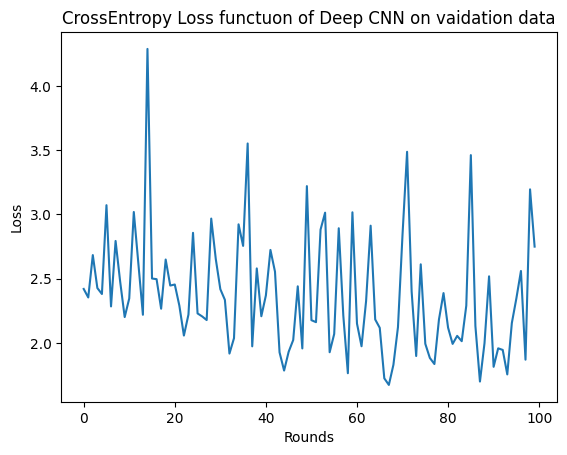

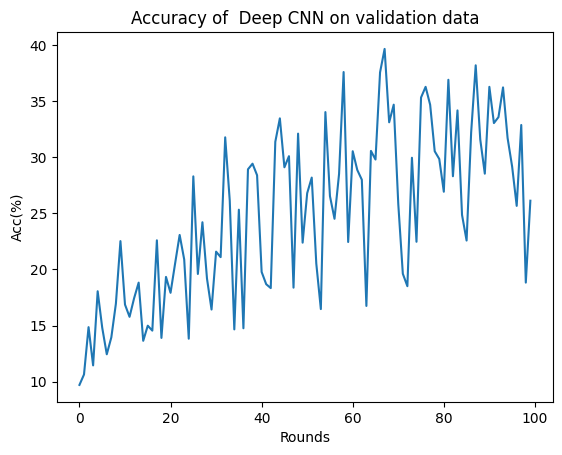

In [31]:
plot_cost, plot_acc = 1, 1
# plot the cost
if plot_cost:
    # plt.plot(train_losses3)
    plt.plot(validation_losses6)
    plt.title("CrossEntropy Loss functuon of Deep CNN on vaidation data")
    plt.ylabel('Loss')
    plt.xlabel('Rounds')
    # plt.legend(labels = ["Train","Validation"])
    plt.show()

if plot_acc:
    # plt.plot(train_accs3)
    plt.plot(val_accs6)
    plt.title("Accuracy of  Deep CNN on validation data")
    plt.ylabel('Acc(%)')
    plt.xlabel('Rounds')
    # plt.legend(labels = ["Train","Validation"])
    plt.show()

In [32]:
PATH = 'Fed_Non_IID_1.pth'
torch.save(Net6.state_dict(), PATH)

## FedProx 訓練

In [33]:
# Model
Net5 =  Deep_CNN(10)
Net5.to(device)

# Define Loss function and Optimizer
criterion5 = nn.CrossEntropyLoss()

train_losses5 = []
validation_losses5 = []

train_accs5 = []
val_accs5 = []

max_rounds = 50
C = 0.1
E = 5
mu = 3
learning_rate = 0.01
w_dict = copy.deepcopy(Net5.state_dict())

# Loop over epochs
for round in tqdm(range(max_rounds)):
    running_trainloss, running_valloss, train_acc = 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0
    clients = random.sample(list(np.arange(n)), k = int(C * n))
    coeffs = [ 1 / len(clients) for i in range(n)]

    for k in w_dict.keys():
        w_dict[k] = torch.zeros_like(w_dict[k])

    # Training
    for i in clients:
        cl_upd = FedProx_ClientUpdate(train_loaders3[i])
        w_prime_dict, train_loss, acc = cl_upd.update(copy.deepcopy(Net5).to(device), E, learning_rate, mu)
        w_dict = cl_upd.FedAvg(w_dict, w_prime_dict, coeffs[i])
        print("Cost of Train data for client %i in round %i for %i epochs: %f" %(i+1, round + 1, E, train_loss))
        running_trainloss += train_loss
        train_acc += acc
        train_cnt += 1

    Net5.load_state_dict(w_dict)

    val_acc = 0
    with torch.set_grad_enabled(False):
        for val_data, val_labels in testloader3:
            # Transfer to GPU
            val_data, val_labels = val_data.to(device), val_labels.to(device)

            # Model computations
            # forward + backward + optimize
            batch_outputs = Net5(val_data)

            val_loss = criterion5(batch_outputs, val_labels.long())

            running_valloss += val_loss.item()

            val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  val_labels.long()) / torch.numel(val_labels)

            val_cnt += 1

    # learning_rate = learning_rate * 0.99
    print("-"*10)
    print("Cost of Train data for in round %i: %f" %(round + 1, running_trainloss / train_cnt))
    print("Cost of Validation data for in round %i: %f" %(round + 1, running_valloss / val_cnt))
    print("Acc of Train data for in round %i: %f" %(round + 1, train_acc / train_cnt * 100))
    print("Acc of Validation data for in round %i: %f" %(round + 1, val_acc / val_cnt * 100))
    print("-"*10)
    train_losses5.append(running_trainloss / train_cnt)
    train_accs5.append(train_acc / train_cnt * 100)
    validation_losses5.append(running_valloss / val_cnt)
    val_accs5.append(val_acc / val_cnt * 100)

  0%|          | 0/50 [00:00<?, ?it/s]

Cost of Train data for client 91 in round 1 for 5 epochs: 6.169140
Cost of Train data for client 66 in round 1 for 5 epochs: 5.846863
Cost of Train data for client 92 in round 1 for 5 epochs: 6.501856
Cost of Train data for client 95 in round 1 for 5 epochs: 6.128329
Cost of Train data for client 64 in round 1 for 5 epochs: 5.902347
Cost of Train data for client 10 in round 1 for 5 epochs: 6.305900
Cost of Train data for client 73 in round 1 for 5 epochs: 5.927393
Cost of Train data for client 36 in round 1 for 5 epochs: 6.193009
Cost of Train data for client 63 in round 1 for 5 epochs: 6.029147
Cost of Train data for client 59 in round 1 for 5 epochs: 5.928400
----------
Cost of Train data for in round 1: 6.093239
Cost of Validation data for in round 1: 2.635225
Acc of Train data for in round 1: 48.643993
Acc of Validation data for in round 1: 10.300008
----------
Cost of Train data for client 96 in round 2 for 5 epochs: 5.060539
Cost of Train data for client 60 in round 2 for 5 epoch

In [34]:
# Loop over epochs
for round in tqdm(range(max_rounds)):
    running_trainloss, running_valloss, train_acc = 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0
    clients = random.sample(list(np.arange(n)), k = int(C * n))
    coeffs = [ 1 / len(clients) for i in range(n)]

    for k in w_dict.keys():
        w_dict[k] = torch.zeros_like(w_dict[k])

    # Training
    for i in clients:
        cl_upd = FedProx_ClientUpdate(train_loaders3[i])
        w_prime_dict, train_loss, acc = cl_upd.update(copy.deepcopy(Net5).to(device), E, learning_rate, mu)
        w_dict = cl_upd.FedAvg(w_dict, w_prime_dict, coeffs[i])
        print("Cost of Train data for client %i in round %i for %i epochs: %f" %(i+1, round + 1, E, train_loss))
        running_trainloss += train_loss
        train_acc += acc
        train_cnt += 1

    Net5.load_state_dict(w_dict)

    val_acc = 0
    with torch.set_grad_enabled(False):
        for val_data, val_labels in testloader3:
            # Transfer to GPU
            val_data, val_labels = val_data.to(device), val_labels.to(device)

            # Model computations
            # forward + backward + optimize
            batch_outputs = Net5(val_data)

            val_loss = criterion5(batch_outputs, val_labels.long())

            running_valloss += val_loss.item()

            val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  val_labels.long()) / torch.numel(val_labels)

            val_cnt += 1

    # learning_rate = learning_rate * 0.99
    print("-"*10)
    print("Cost of Train data for in round %i: %f" %(round + 1, running_trainloss / train_cnt))
    print("Cost of Validation data for in round %i: %f" %(round + 1, running_valloss / val_cnt))
    print("Acc of Train data for in round %i: %f" %(round + 1, train_acc / train_cnt * 100))
    print("Acc of Validation data for in round %i: %f" %(round + 1, val_acc / val_cnt * 100))
    print("-"*10)

    train_acc = train_acc.cpu()
    val_acc = val_acc.cpu()

    train_losses5.append(running_trainloss / train_cnt)
    train_accs5.append(train_acc / train_cnt * 100)
    validation_losses5.append(running_valloss / val_cnt)
    val_accs5.append(val_acc / val_cnt * 100)

  0%|          | 0/50 [00:00<?, ?it/s]

Cost of Train data for client 30 in round 1 for 5 epochs: 9.753995
Cost of Train data for client 41 in round 1 for 5 epochs: 9.006879
Cost of Train data for client 17 in round 1 for 5 epochs: 7.866294
Cost of Train data for client 67 in round 1 for 5 epochs: 10.582721
Cost of Train data for client 97 in round 1 for 5 epochs: 2.148248
Cost of Train data for client 27 in round 1 for 5 epochs: 10.051050
Cost of Train data for client 3 in round 1 for 5 epochs: 7.532805
Cost of Train data for client 22 in round 1 for 5 epochs: 9.967752
Cost of Train data for client 92 in round 1 for 5 epochs: 1.985628
Cost of Train data for client 44 in round 1 for 5 epochs: 8.778807
----------
Cost of Train data for in round 1: 7.767418
Cost of Validation data for in round 1: 2.349215
Acc of Train data for in round 1: 76.248001
Acc of Validation data for in round 1: 20.890015
----------
Cost of Train data for client 90 in round 2 for 5 epochs: 9.665126
Cost of Train data for client 6 in round 2 for 5 epoch

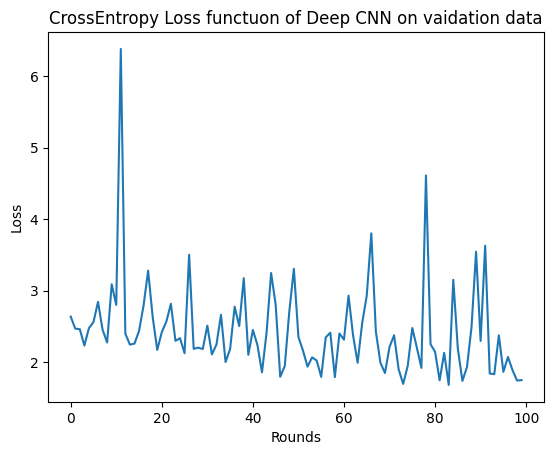

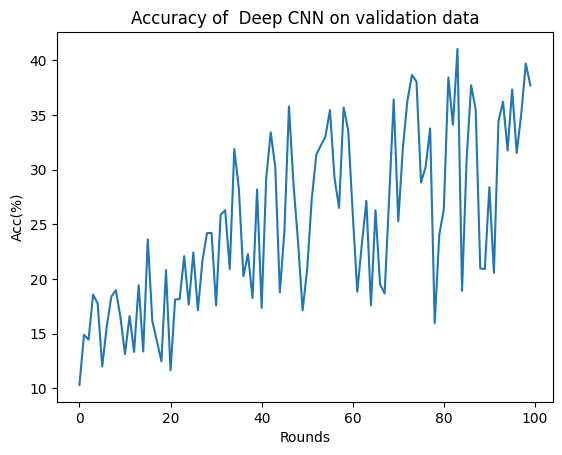

In [35]:
plot_cost, plot_acc = 1, 1
# plot the cost
if plot_cost:
    # plt.plot(train_losses3)
    plt.plot(validation_losses5)
    plt.title("CrossEntropy Loss functuon of Deep CNN on vaidation data")
    plt.ylabel('Loss')
    plt.xlabel('Rounds')
    # plt.legend(labels = ["Train","Validation"])
    plt.show()

if plot_acc:
    # plt.plot(train_accs3)
    plt.plot(val_accs5)
    plt.title("Accuracy of  Deep CNN on validation data")
    plt.ylabel('Acc(%)')
    plt.xlabel('Rounds')
    # plt.legend(labels = ["Train","Validation"])
    plt.show()

In [36]:
PATH = 'Fed_Non_IID_2.pth'
torch.save(Net5.state_dict(), PATH)

# 重點

## 聯邦學習可以盡可能逼近與完全集中訓練的效果

## FedProx 對於 Non-IID 資料有很好的助益